# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import pytz
import datetime 
import astral
import astropy.time as aptime
import os
import glob
from scipy import stats

In [121]:
from matplotlib import rc
from matplotlib import rcParams
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15)

rc('axes', labelsize=20) 
rc('axes', linewidth=2)

rcParams['axes.titlesize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['patch.linewidth'] = 1
#rcParams['axes.titlepad'] = 30
rcParams['axes.labelpad'] = 10

# file paths & save paths

In [2]:
data_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/datatables/'

In [3]:
save_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Results/sp_psd_slope_correlations'

In [4]:
txt_file1 = pd.read_csv(data_path + 'IFS_RawContrast_Gemini_env_20180530_all_seeing.csv')
txt_file1_copy = copy.copy(txt_file1)
raw_contrast_data= pd.DataFrame(txt_file1_copy)
print len(raw_contrast_data)

raw_contrast_data['dts'] = aptime.Time(raw_contrast_data['MJDOBS'], format='mjd').datetime 
raw_contrast_data['dts'] = raw_contrast_data['dts'].dt.tz_localize(pytz.UTC)

24155


# Read all the CSV files and concatentae all of them

In [76]:
allFiles = glob.glob(data_path + "/sp_psd_summary*.csv")

list_ = []

for file_ in allFiles[0:3]:
    df = pd.read_csv(file_,index_col=0)
    list_.append(df)

frame = pd.concat(list_, axis = 0, ignore_index = True)

In [5]:
txt_file2 = pd.read_csv(data_path + 'sp_psd_summary20181204.csv',index_col=0) 
txt_file2_copy = copy.copy(txt_file2)

sp_psd_data = pd.DataFrame(txt_file2_copy)
sp_psd_data['dts'] = pd.to_datetime(sp_psd_data.loc[:,'filename'].str.split('_').str.get(2) + '_' + sp_psd_data.loc[:,'filename'].str.split('_').str.get(3),
              utc=True, format = '%Y.%m.%d_%H.%M.%S')

sp_psd_data['dts'] = sp_psd_data['dts'].dt.tz_localize(pytz.UTC)

In [6]:
sp_psd_data

,filename,path,slope,whenstr,dts
0,aored_When_2016.10.13_21.17.57_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.120774,20161013211757,2016-10-13 21:17:57+00:00
1,aored_When_2016.10.13_21.52.12_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.242655,20161013215212,2016-10-13 21:52:12+00:00
2,aored_When_2016.10.13_22.30.52_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.137460,20161013223052,2016-10-13 22:30:52+00:00
3,aored_When_2016.10.13_21.53.13_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.146524,20161013215313,2016-10-13 21:53:13+00:00
4,aored_When_2016.10.13_22.36.13_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.052361,20161013223613,2016-10-13 22:36:13+00:00
5,aored_When_2016.10.13_21.56.13_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.310145,20161013215613,2016-10-13 21:56:13+00:00
6,aored_When_2016.10.13_22.3.48_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.252667,2016101322348,2016-10-13 22:03:48+00:00
7,aored_When_2016.10.13_21.45.3_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.274301,2016101321453,2016-10-13 21:45:03+00:00
8,aored_When_2016.12.21_2.40.9_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.531664,201612212409,2016-12-21 02:40:09+00:00
9,aored_When_2016.12.21_3.53.43_poldm_phase.fits,/home/sda/mtallis/PhaseScripts/aotelem/Reduced...,-3.345508,2016122135343,2016-12-21 03:53:43+00:00


# Filter data

In [21]:
def filter_data(data, imag = 10., tau = 1., see = 2., all_cond = True):
    "This selects all rows of input dataframe that satisfy conditions set by the user"
    
    date1 = datetime.date(year = 2014, month = 1, day =1)
    
    #  AO system requirements
    cond1 = data['dts'] > date1 
    cond2 = data['COADDS'] == 1
    cond3 = (data['OBSMODE'] == 'H_coron')|(data['OBSMODE'] == 'Spec')
    cond4 = data['AOFRAMES'] == 1000

    #  Good seeing conditions
    cond5 = data['IMAG'] < imag #Bright Stars
    cond6 = data['MASSTAU'] > tau  # slow moving turbulence [ms]
    cond7 = data['DIMMSEE'] < see  # smaller scale turbulence ["]
    
    if all_cond:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7)[0]  
        print len(ind)
    else:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5)[0]  
        print len(ind)

    filtered_data = data.iloc[ind]
    #filtered_data = filtered_data.dropna(subset = ['CONTR040','cal_wfe','M1_avg','TAMBIENT','Outside_OE_temperature'])
    
    new_ind = np.arange(len(filtered_data))
    filtered_data = filtered_data.set_index(new_ind)
        
    return filtered_data

In [75]:
r = filter_data(raw_contrast_data,all_cond=True)

2959


# Merge PSD data with IFS data

In [7]:
sp_psd_raw_IFS_data =  pd.merge_asof(sp_psd_data[['slope','dts','filename','path']].sort_values('dts'),raw_contrast_data, on='dts',tolerance=pd.Timedelta('1min'))

In [8]:
sp_psd_raw_IFS_data = sp_psd_raw_IFS_data.dropna(subset=['slope','M1_avg'])

In [9]:
print sum(np.isfinite(sp_psd_raw_IFS_data['TAMBIENT']))

562


# Plotting

No grouping

<IPython.core.display.Javascript object>


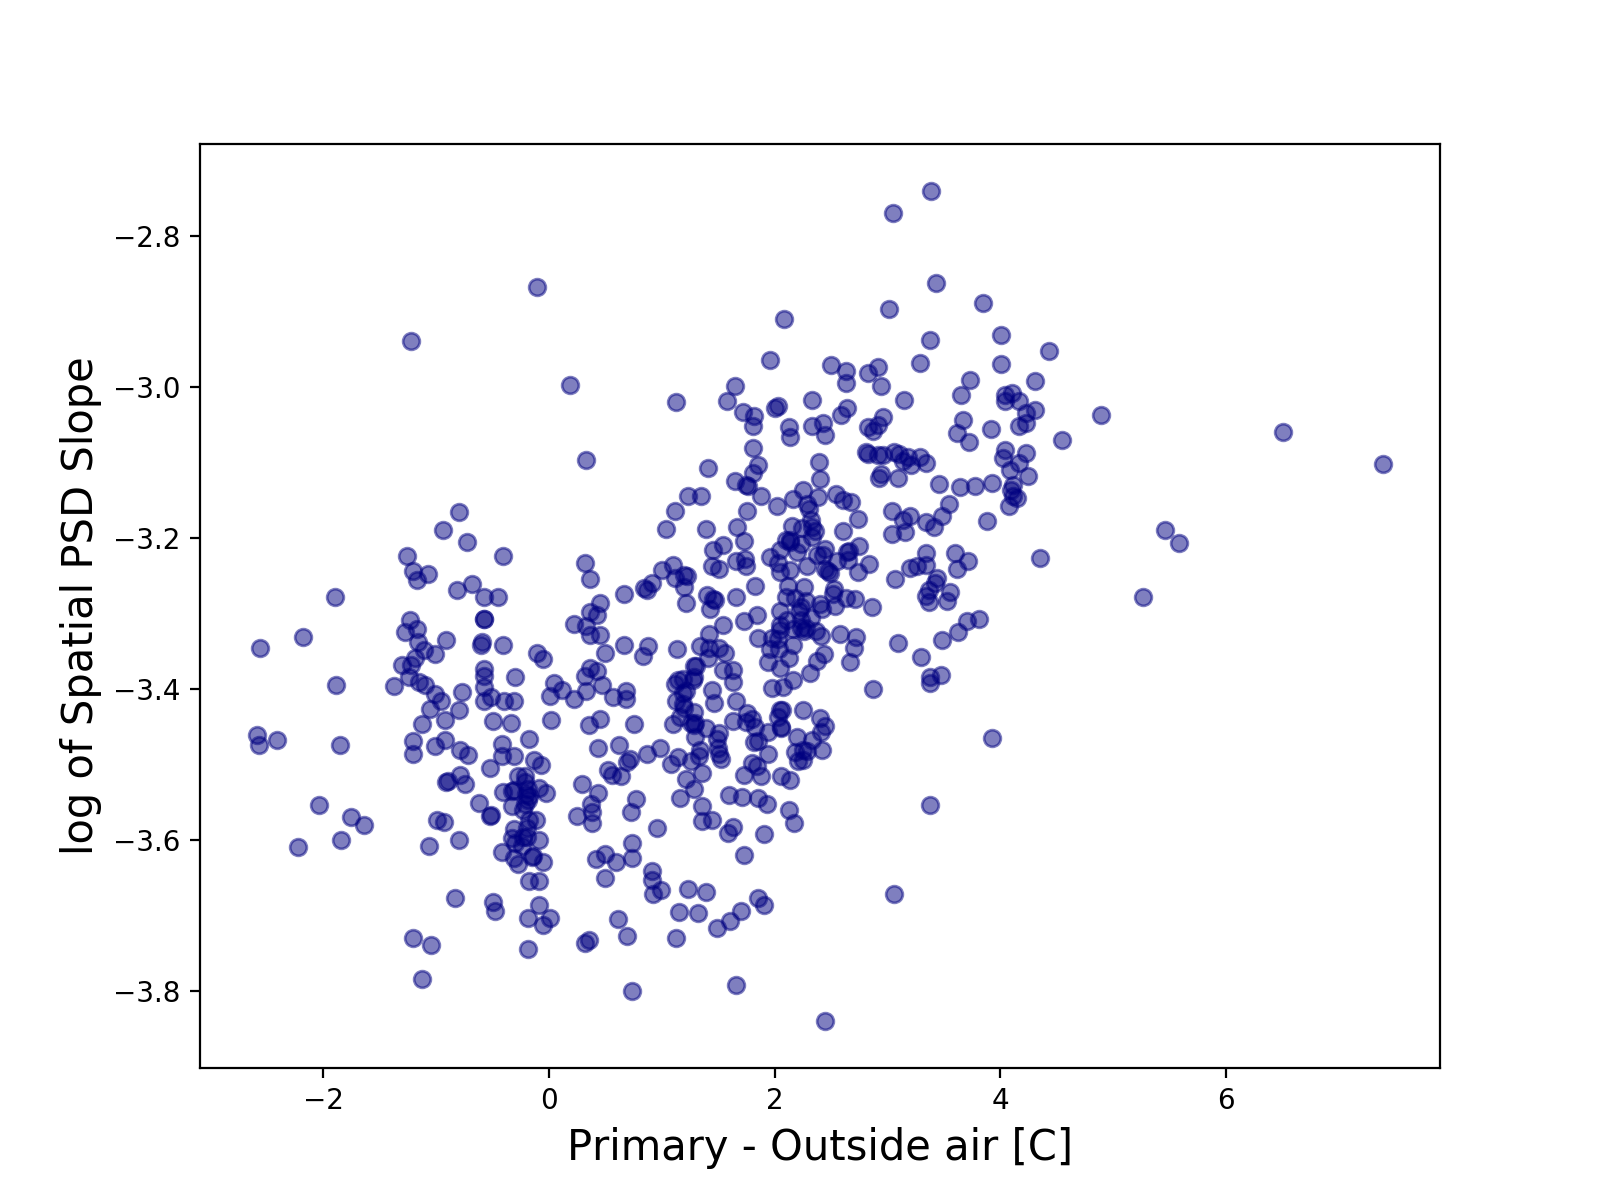

562


In [10]:
%matplotlib notebook

plt.figure(figsize=[8,6])
x = (sp_psd_raw_IFS_data['M1_avg']-sp_psd_raw_IFS_data['TAMBIENT'])
y = sp_psd_raw_IFS_data['slope']

print(sum(np.isfinite(y)))
plt.scatter(x,y,alpha=.5,c='navy')

plt.ylabel('log of Spatial PSD Slope',fontsize=15)
plt.xlabel('Primary - Outside air [C]',fontsize=15)

#plt.savefig(save_path+'sp_psd_slope_vs_delT_20181205.png')
#plt.plot(sp_psd_raw_IFS_data['slope'],'.',alpha=.5)

Number of unique objects and nights

In [89]:
print(len(pd.unique(sp_psd_raw_IFS_data['OBJNAME'])))
print(len(pd.unique(sp_psd_raw_IFS_data['night_number'])))

522
139


In [148]:
sp_psd_raw_IFS_data.keys()

Index([u'DATAFILE', u'DATALAB', u'OBJNAME', u'DATESTR', u'UTSTART', u'MJDOBS',
       u'ITIME', u'COADDS', u'OBSMODE', u'DISPERSR', u'IFSFILT', u'AOFRAMES',
       u'AOSPATIA', u'HMAG', u'IMAG', u'AOFLUX', u'RawDPwfe', u'PAR_ANG',
       u'PA', u'IAA', u'AZIMUTH', u'ELEVATIO', u'AIRMASS', u'AMSTART',
       u'AMEND', u'WINDM2', u'WINDM2DR', u'WINDDIRE', u'WINDSPEE', u'TAMBIENT',
       u'OMSATEMP', u'GLITEMP', u'GLOTEMP', u'MASSSEE', u'MASSTAU', u'DIMMSEE',
       u'MASS05CN', u'MASS1CN2', u'MASS2CN2', u'MASS4CN2', u'MASS8CN2',
       u'MASS16CN', u'MASSISOP', u'DRPDATE', u'CONTR025', u'CONTR040',
       u'CONTR080', u'dts', u'OE_Interior_Air_temperature',
       u'OMSS_AO_Bench_temperature', u'OMSS_Interface_Structure_temperature',
       u'OMSS_Mounting_Frame_temperature', u'Outside_OE_temperature',
       u'cal_wfe', u'T_M1+Y', u'T_M1-Y', u'T_TrussAirLow+X',
       u'T_TrussAirMid+X', u'T_TrussAirTop+X', u'T_TrussSurLow+X',
       u'T_TrussSurMid+X', u'T_TrussSurTop+X', u'T_twr', u'

With grouping

In [11]:
grouped = sp_psd_raw_IFS_data.groupby(['night_number', 'OBJNAME'], as_index= False).mean().dropna(subset = ['slope','M1_avg'])

In [30]:
less = np.where(np.abs(grouped['M1_avg']-grouped['T_twr'])<1.)[0]
more = np.where(np.abs(grouped['M1_avg']-grouped['T_twr'])>=1.)[0]

grouped.loc[more,'slope'].mean()

-3.2884301631855575

222


<IPython.core.display.Javascript object>


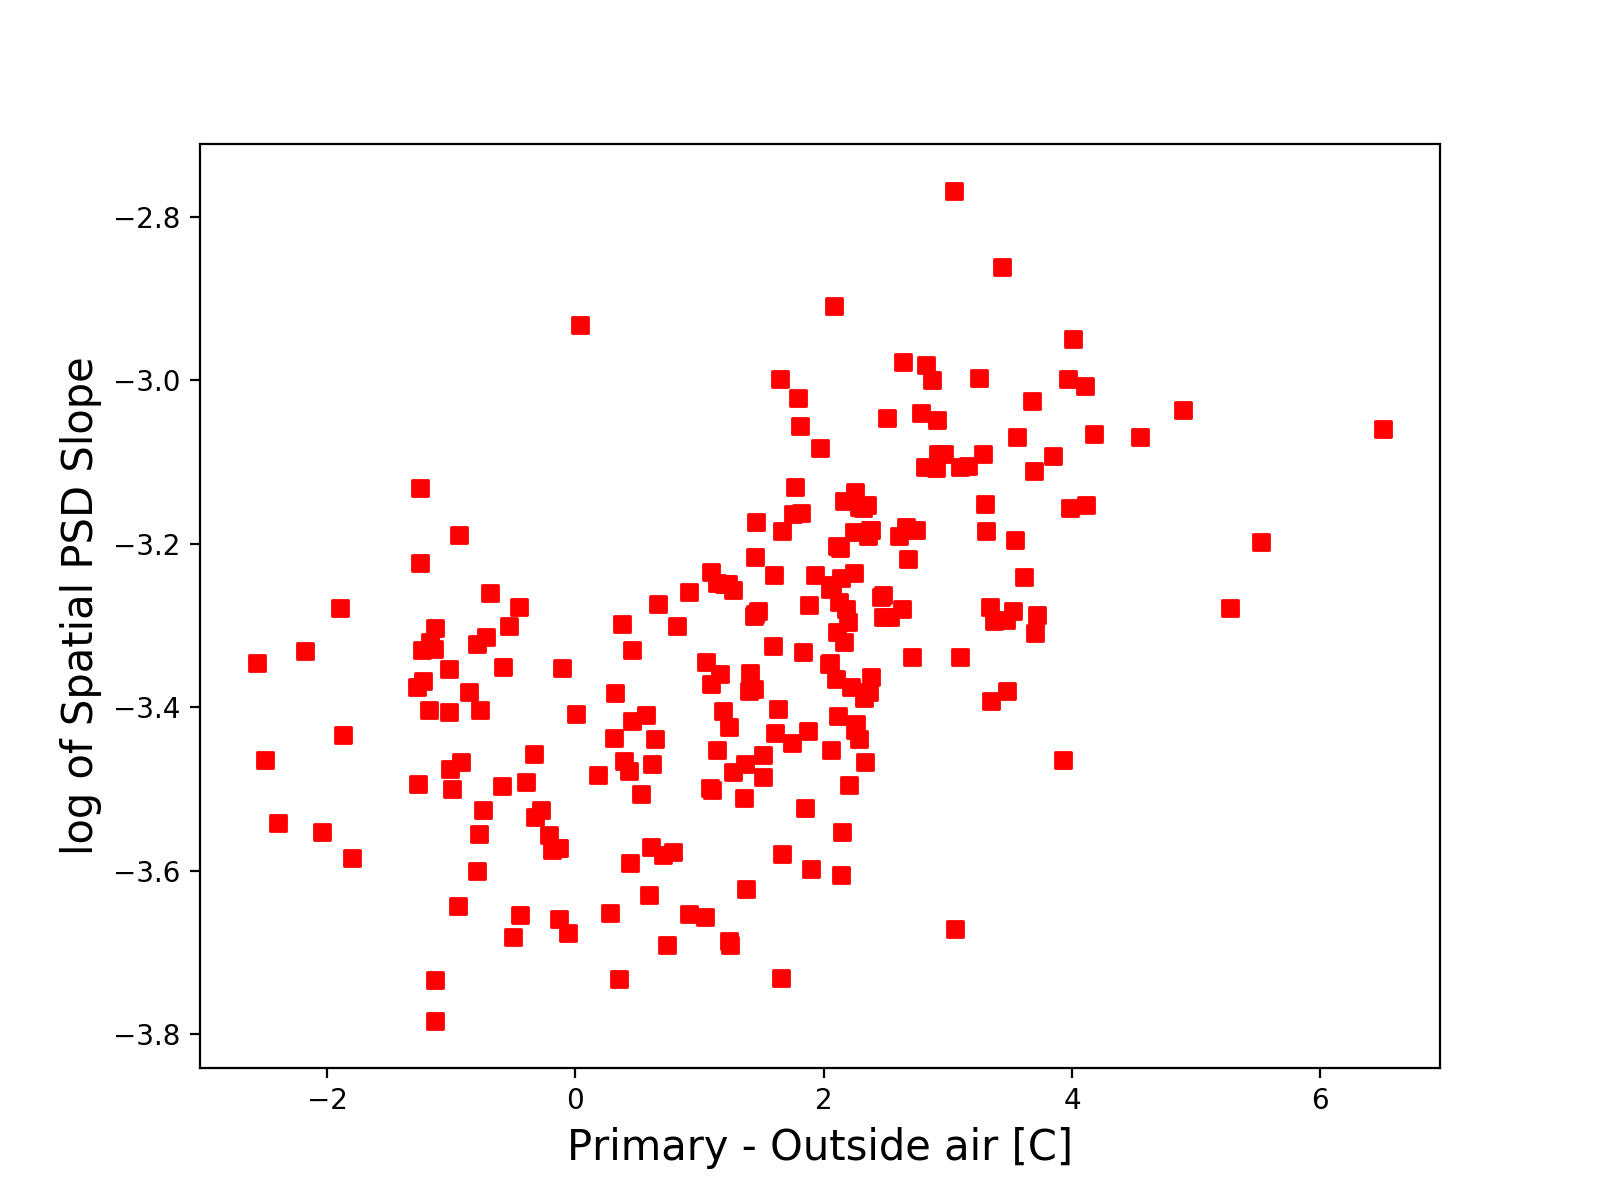

In [12]:
%matplotlib notebook

x = grouped['M1_avg']-grouped['TAMBIENT']
y = grouped['slope']
print(sum(np.isfinite(y)))


plt.figure(figsize=[8,6])
plt.scatter(x,y,c='red',marker='s')
plt.ylabel('log of Spatial PSD Slope',fontsize=15)
plt.xlabel('Primary - Outside air [C]',fontsize=15)
#plt.colorbar()


#plt.savefig(save_path+'sp_psd_slope_vs_delT_grouped_20181205.pdf')


#plt.savefig(save_path+'sp_psd_slope_vs_delT_night_20181201.pdf')
#plt.plot(sp_psd_raw_IFS_data['slope'],'.',alpha=.5)

In [195]:
ind = np.where(grouped['slope'] == np.max(grouped['slope']))[0]

In [112]:
def search_for_dome_seeing(data, sample_size, presence = True):
    
    cut = 0
    sample = set()
    
    if presence:
        
        while len(sample) <= sample_size:
            tau0 = data.MASSTAU.sort_values(ascending = False)[0:cut]
            mirror_to_air_temp = np.abs(data.M1_avg - data.T_twr).sort_values(ascending = False)[0:cut]
            contrast = data.CONTR040.sort_values(ascending = False)[0:cut]
            psd_slope = data.slope.sort_values(ascending = False)[0:cut]
            sample = set(tau0.index) & set(mirror_to_air_temp.index) & set(contrast.index) & set(psd_slope.index)
            cut = cut + 1
            
    else:
        
        while len(sample) <= sample_size:
            tau0 = data.MASSTAU.sort_values(ascending = False)[0:cut]
            mirror_to_air_temp = np.abs(data.M1_avg - data.T_twr).sort_values()[0:cut]
            contrast = data.CONTR040.sort_values()[0:cut]
            psd_slope = data.slope.sort_values(ascending = True)[0:cut]
            sample = set(tau0.index) & set(mirror_to_air_temp.index) & set(contrast.index) & set(psd_slope.index)
            cut = cut + 1
    return list(sample)  

In [113]:
sp_psd_raw_IFS_data.loc[search_for_dome_seeing(sp_psd_raw_IFS_data,10,presence=True),
                       ['dts','CONTR040','M1_avg','TAMBIENT','MASSTAU','slope','IMAG','filename']].sort_values("CONTR040",ascending = True)

,dts,CONTR040,M1_avg,TAMBIENT,MASSTAU,slope,filename
1182,2016-02-27 00:56:57+00:00,0.000160,15.725,11.8,2.43,-3.126159,aored_When_2016.2.27_0.56.57_poldm_phase.fits
2010,2016-11-19 02:20:58+00:00,0.000163,14.080,10.3,1.36,-3.129967,aored_When_2016.11.19_2.20.58_poldm_phase.fits
663,2015-11-06 01:06:42+00:00,0.000166,9.505,7.2,1.89,-3.161651,aored_When_2015.11.6_1.6.42_poldm_phase.fits
2006,2016-11-19 00:54:30+00:00,0.000177,14.205,10.1,1.01,-3.006831,aored_When_2016.11.19_0.54.30_poldm_phase.fits
1144,2016-02-26 03:43:31+00:00,0.000177,17.250,14.5,1.10,-3.210009,aored_When_2016.2.26_3.43.31_poldm_phase.fits
1166,2016-02-27 00:25:19+00:00,0.000179,15.830,11.6,1.87,-3.086619,aored_When_2016.2.27_0.25.19_poldm_phase.fits
1167,2016-02-27 00:26:07+00:00,0.000179,15.830,11.6,1.87,-3.033373,aored_When_2016.2.27_0.26.7_poldm_phase.fits
2009,2016-11-19 02:15:53+00:00,0.000182,14.115,10.2,1.06,-3.054625,aored_When_2016.11.19_2.15.53_poldm_phase.fits
1490,2016-03-28 00:57:36+00:00,0.000189,14.350,12.1,2.05,-3.136037,aored_When_2016.3.28_0.57.36_poldm_phase.fits
1922,2016-10-15 00:42:40+00:00,0.000221,10.815,7.8,1.24,-2.895512,aored_When_2016.10.15_0.42.40_poldm_phase.fits


In [114]:
sp_psd_raw_IFS_data.loc[search_for_dome_seeing(sp_psd_raw_IFS_data,10,presence=False),
                       ['dts','CONTR040','M1_avg','TAMBIENT','MASSTAU','slope','filename']].sort_values("CONTR040",ascending = False)

,dts,CONTR040,M1_avg,TAMBIENT,MASSTAU,slope,filename
1672,2016-09-18 02:41:01+00:00,0.000097,12.860,14.5,2.51,-3.579841,aored_When_2016.9.18_2.41.1_poldm_phase.fits
251,2015-05-04 07:13:13+00:00,0.000096,8.485,8.7,2.25,-3.515309,aored_When_2015.5.4_7.13.13_poldm_phase.fits
578,2015-09-01 04:13:52+00:00,0.000090,16.500,17.0,1.43,-3.441340,aored_When_2015.9.1_4.13.52_poldm_phase.fits
515,2015-08-31 00:50:54+00:00,0.000088,15.190,16.2,0.80,-3.475448,aored_When_2015.8.31_0.50.54_poldm_phase.fits
1820,2016-09-21 02:33:09+00:00,0.000079,16.085,14.8,4.81,-3.429967,aored_When_2016.9.21_2.33.9_poldm_phase.fits
1716,2016-09-19 03:16:08+00:00,0.000074,15.270,16.4,3.89,-3.783225,aored_When_2016.9.19_3.16.8_poldm_phase.fits
585,2015-09-01 05:56:16+00:00,0.000068,16.605,17.6,0.81,-3.573586,aored_When_2015.9.1_5.56.16_poldm_phase.fits
589,2015-09-01 06:28:06+00:00,0.000060,16.595,16.9,1.45,-3.603942,aored_When_2015.9.1_6.28.6_poldm_phase.fits
587,2015-09-01 06:10:44+00:00,0.000055,16.590,17.5,0.81,-3.522135,aored_When_2015.9.1_6.10.44_poldm_phase.fits
342,2015-07-04 03:27:52+00:00,0.000047,7.180,8.1,1.87,-3.466565,aored_When_2015.7.4_3.27.52_poldm_phase.fits
